In [1]:
# Traffic Sign Classification - EDA and Model Training
# =====================================================

# # Traffic Sign Classification Project
# Goal: Build a CNN model to classify 43 different types of German traffic signs
# Use Case: Autonomous vehicles, Advanced Driver Assistance Systems (ADAS)
# Dataset: GTSRB (German Traffic Sign Recognition Benchmark)

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.17.0
GPU Available: []


In [3]:
# 1. Data Loading and Initial Exploration

# Load Data Paths
data_dir = Path('data')
train_dir = data_dir / 'Train'
test_dir = data_dir / 'Test'

# Get all class directories
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Class Names Mapping
# Based on GTSRB documentation
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

# Count Images Per Class
class_counts = {}
for class_id in classes:
    class_path = train_dir / class_id
    images = list(class_path.glob('*.png')) + list(class_path.glob('*.ppm'))
    class_counts[int(class_id)] = len(images)

# Create DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df_counts['Name'] = df_counts['Class'].map(class_names)
df_counts = df_counts.sort_values('Count', ascending=False)

print(f"\nTotal training images: {df_counts['Count'].sum()}")
print(f"Min images per class: {df_counts['Count'].min()}")
print(f"Max images per class: {df_counts['Count'].max()}")
print(f"Average images per class: {df_counts['Count'].mean():.1f}")

Number of classes: 43
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']

Total training images: 39209
Min images per class: 210
Max images per class: 2250
Average images per class: 911.8


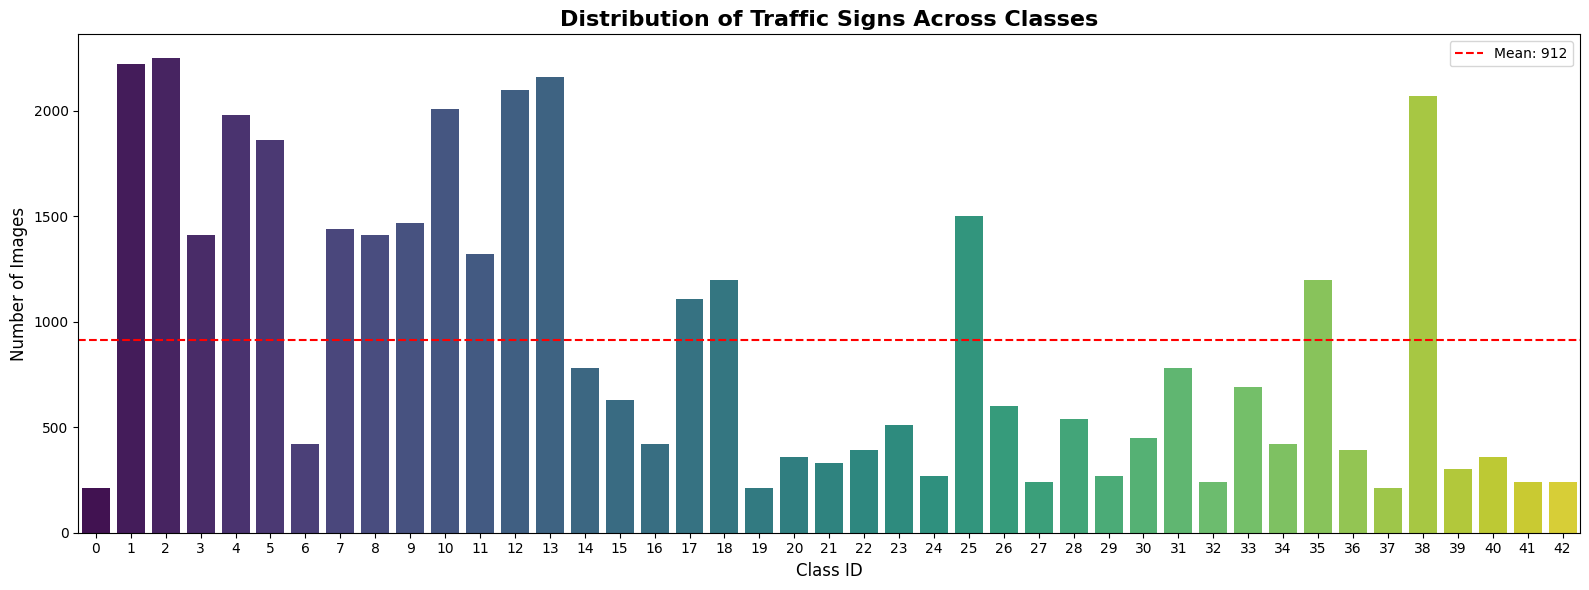


📊 Top 5 Most Common Signs:
    Class  Count                  Name
12      2   2250  Speed limit (50km/h)
1       1   2220  Speed limit (30km/h)
5      13   2160                 Yield
4      12   2100         Priority road
32     38   2070            Keep right

📊 Top 5 Least Common Signs:
    Class  Count                                 Name
26     32    240  End of all speed and passing limits
20     27    240                          Pedestrians
31     37    210                  Go straight or left
11     19    210          Dangerous curve to the left
0       0    210                 Speed limit (20km/h)


In [4]:
# 2. Class Distribution Analysis

# Plot Class Distribution
plt.figure(figsize=(16, 6))
sns.barplot(data=df_counts, x='Class', y='Count', palette='viridis')
plt.title('Distribution of Traffic Signs Across Classes', fontsize=16, fontweight='bold')
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)
plt.axhline(y=df_counts['Count'].mean(), color='r', linestyle='--', label=f"Mean: {df_counts['Count'].mean():.0f}")
plt.legend()
plt.tight_layout()
plt.show()

# Top and Bottom Classes
print("\n📊 Top 5 Most Common Signs:")
print(df_counts.head())

print("\n📊 Top 5 Least Common Signs:")
print(df_counts.tail())

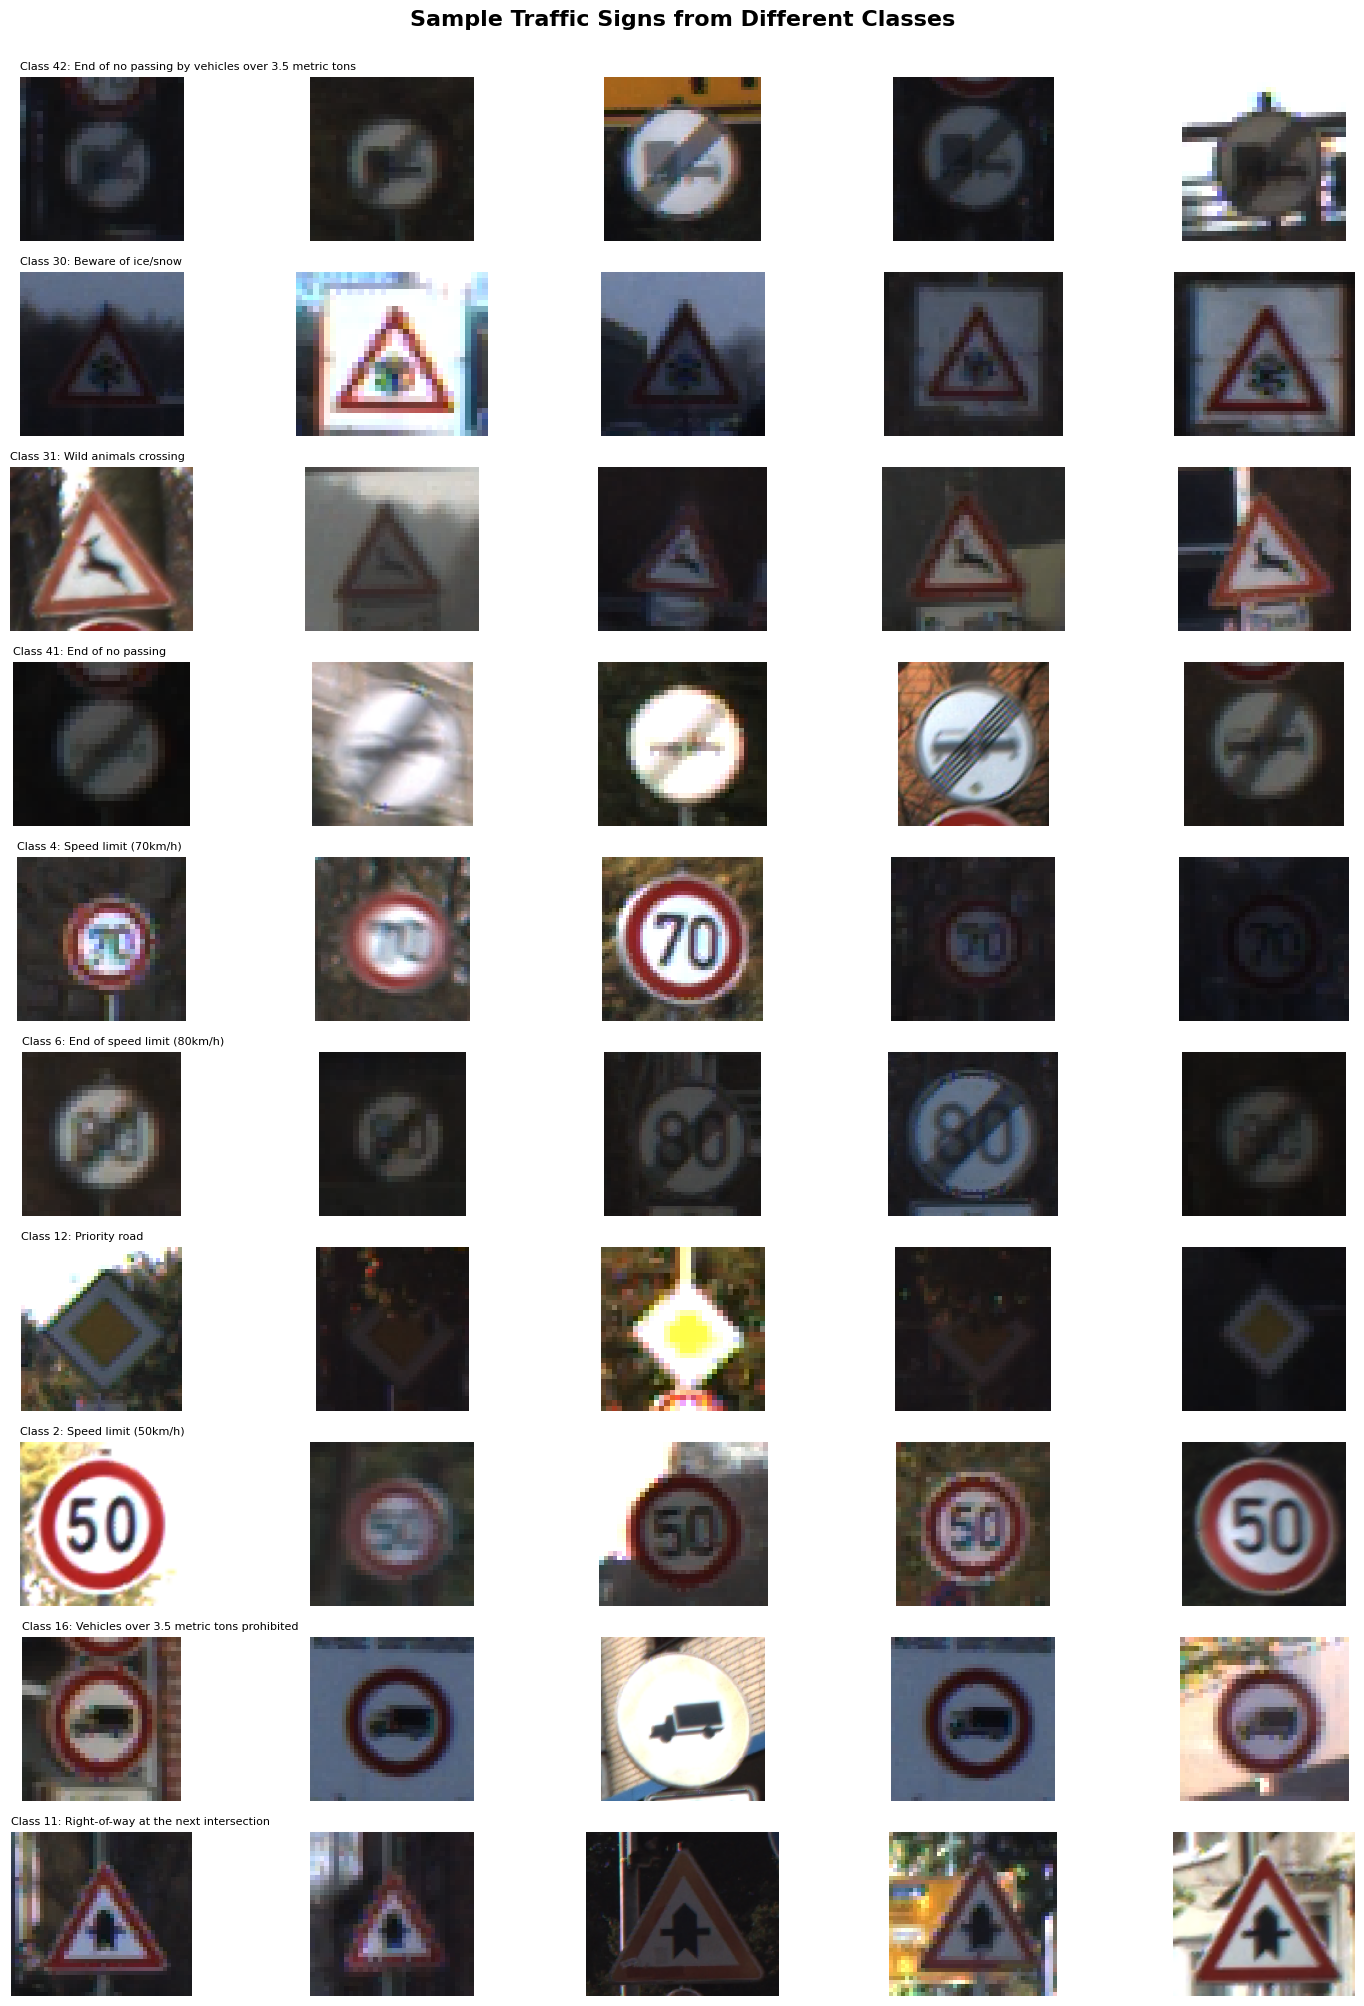

In [5]:
# 3. Sample Images Visualization

# Display Sample Images from Each Class
def show_sample_images(num_classes_to_show=10, images_per_class=5):
    """Display sample images from multiple classes"""
    fig, axes = plt.subplots(num_classes_to_show, images_per_class, 
                             figsize=(15, num_classes_to_show * 2))
    
    selected_classes = np.random.choice(classes, num_classes_to_show, replace=False)
    
    for i, class_id in enumerate(selected_classes):
        class_path = train_dir / class_id
        images = list(class_path.glob('*.png')) + list(class_path.glob('*.ppm'))
        
        # Sample random images
        sample_images = np.random.choice(images, min(images_per_class, len(images)), replace=False)
        
        for j, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                class_name = class_names[int(class_id)]
                axes[i, j].set_title(f"Class {class_id}: {class_name}", 
                                    fontsize=8, loc='left')
    
    plt.suptitle('Sample Traffic Signs from Different Classes', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

show_sample_images(num_classes_to_show=10, images_per_class=5)

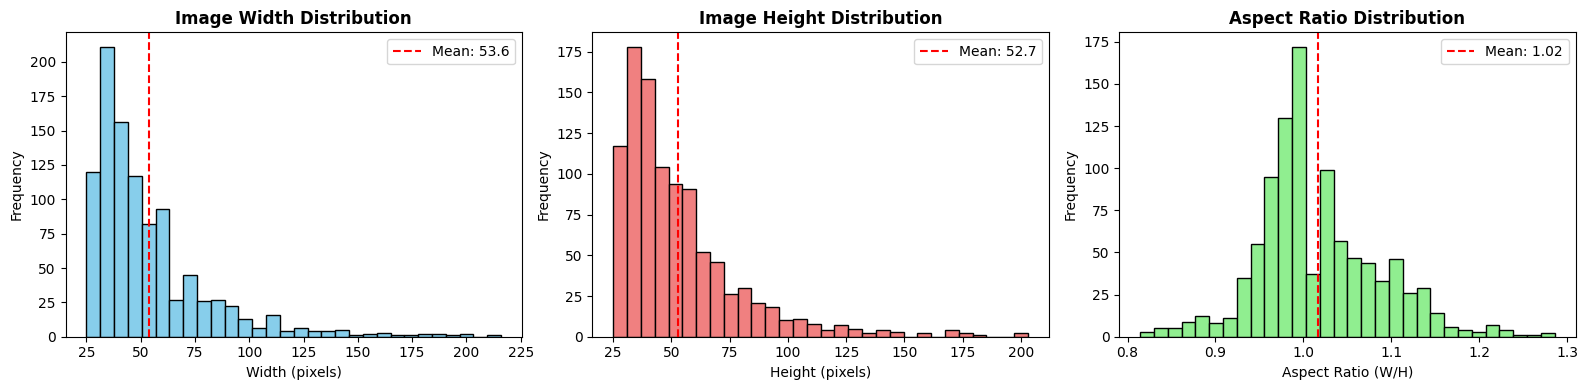


📏 Image Size Statistics:
Width - Min: 25, Max: 216, Mean: 53.6
Height - Min: 25, Max: 203, Mean: 52.7
Aspect Ratio - Mean: 1.02


In [6]:
# 4. Image Properties Analysis

# Analyze Image Sizes
def analyze_image_properties(sample_size=1000):
    """Analyze dimensions and properties of images"""
    widths = []
    heights = []
    aspects = []
    
    # Sample random images
    all_images = []
    for class_id in classes[:5]:  # Sample from first 5 classes for speed
        class_path = train_dir / class_id
        images = list(class_path.glob('*.png')) + list(class_path.glob('*.ppm'))
        all_images.extend(images[:200])  # Take 200 from each
    
    sample = np.random.choice(all_images, min(sample_size, len(all_images)), replace=False)
    
    for img_path in sample:
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        aspects.append(w/h)
    
    return widths, heights, aspects

widths, heights, aspects = analyze_image_properties()

# Plot Image Properties
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Image Width Distribution', fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(widths), color='r', linestyle='--', label=f'Mean: {np.mean(widths):.1f}')
axes[0].legend()

# Height distribution
axes[1].hist(heights, bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Image Height Distribution', fontweight='bold')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(heights), color='r', linestyle='--', label=f'Mean: {np.mean(heights):.1f}')
axes[1].legend()

# Aspect ratio
axes[2].hist(aspects, bins=30, color='lightgreen', edgecolor='black')
axes[2].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(aspects), color='r', linestyle='--', label=f'Mean: {np.mean(aspects):.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📏 Image Size Statistics:")
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
print(f"Aspect Ratio - Mean: {np.mean(aspects):.2f}")

Target image size: 48x48
Batch size: 128
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.

Training samples: 31368
Validation samples: 7841
Number of classes: 43


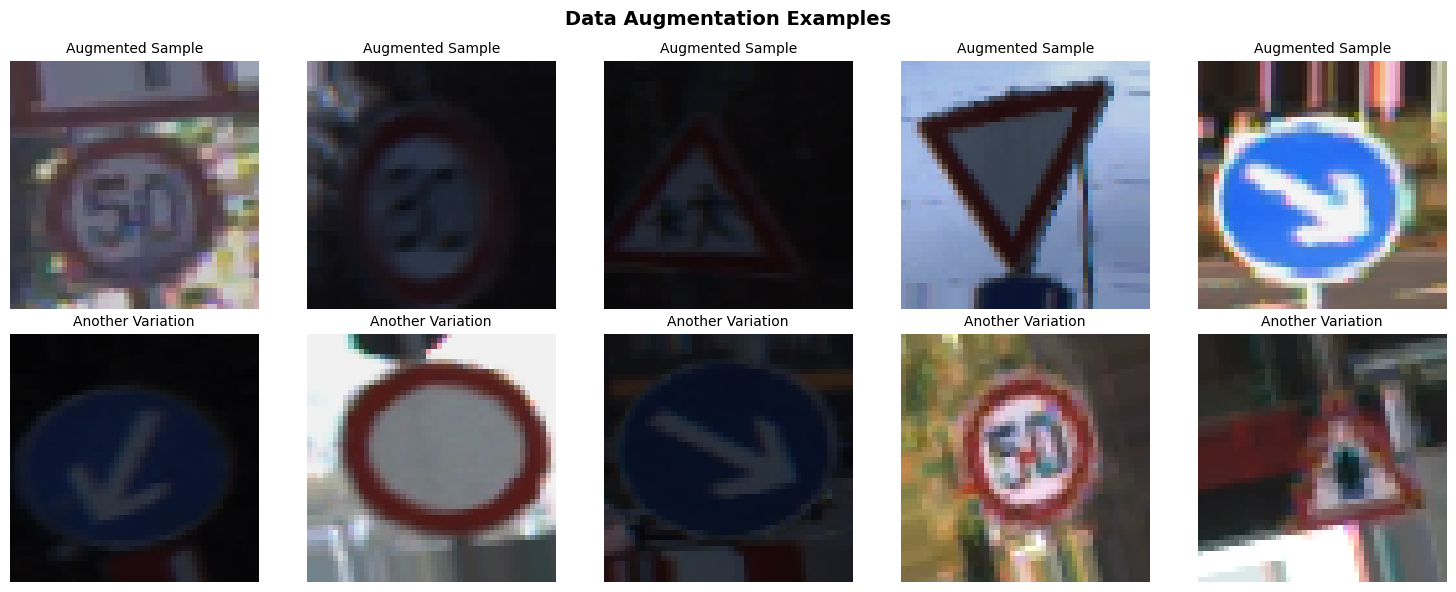

In [7]:
# 5. Data Preprocessing

# Set Image Parameters
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

print(f"Target image size: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch size: {BATCH_SIZE}")

# Create Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation/Test generator (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

# Visualize Augmentation
def show_augmentation(generator, num_images=5):
    """Display original and augmented images"""
    x_batch, y_batch = next(generator)
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Original (approximately, since we rescaled)
        axes[0, i].imshow(x_batch[i])
        axes[0, i].axis('off')
        axes[0, i].set_title('Augmented Sample', fontsize=10)
    
    # Get another batch to show variation
    x_batch2, _ = next(generator)
    for i in range(num_images):
        axes[1, i].imshow(x_batch2[i])
        axes[1, i].axis('off')
        axes[1, i].set_title('Another Variation', fontsize=10)
    
    plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_augmentation(train_generator)

In [9]:
# 6. Model Building

# Model 1: Simple CNN (Baseline)
def build_simple_cnn():
    """Simple CNN architecture as baseline"""
    model = models.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Model 2: MobileNetV2 (Transfer Learning)
def build_mobilenet():
    """MobileNetV2 with transfer learning"""
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Model 3: EfficientNetB0 (Transfer Learning)
def build_efficientnet():
    """EfficientNetB0 with transfer learning"""
    base_model = EfficientNetB0(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# 7. Model Training

# Training Configuration
EPOCHS = 20

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'model/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train Simple CNN
print("\n" + "="*50)
print("Training Simple CNN (Baseline)")
print("="*50)

model_simple = build_simple_cnn()
model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_simple.summary()

history_simple = model_simple.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Train MobileNetV2
print("\n" + "="*50)
print("Training MobileNetV2")
print("="*50)

model_mobile = build_mobilenet()
model_mobile.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_mobile = model_mobile.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Train EfficientNetB0
print("\n" + "="*50)
print("Training EfficientNetB0")
print("="*50)

model_efficient = build_efficientnet()
model_efficient.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_efficient = model_efficient.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Training Simple CNN (Baseline)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,739 (2.40 MB)

 Trainable params: 629,291 (2.40 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3360 - loss: 2.6356
Epoch 1: val_accuracy improved from None to 0.17204, saving model to model/best_model.h5



Epoch 1: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.4912 - loss: 1.8202 - val_accuracy: 0.1720 - val_loss: 4.1042 - learning_rate: 0.0010
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7667 - loss: 0.7245
Epoch 2: val_accuracy improved from 0.17204 to 0.72274, saving model to model/best_model.h5



Epoch 2: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.8083 - loss: 0.5914 - val_accuracy: 0.7227 - val_loss: 0.9780 - learning_rate: 0.0010
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8910 - loss: 0.3289
Epoch 3: val_accuracy improved from 0.72274 to 0.89402, saving model to model/best_model.h5



Epoch 3: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 73s 296ms/step - accuracy: 0.8989 - loss: 0.3110 - val_accuracy: 0.8940 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9331 - loss: 0.2069
Epoch 4: val_accuracy improved from 0.89402 to 0.92514, saving model to model/best_model.h5



Epoch 4: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.9392 - loss: 0.1890 - val_accuracy: 0.9251 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9556 - loss: 0.1450
Epoch 5: val_accuracy improved from 0.92514 to 0.93432, saving model to model/best_model.h5



Epoch 5: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 69s 281ms/step - accuracy: 0.9533 - loss: 0.1496 - val_accuracy: 0.9343 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9594 - loss: 0.1249
Epoch 6: val_accuracy did not improve from 0.93432
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 266ms/step - accuracy: 0.9646 - loss: 0.1112 - val_accuracy: 0.8685 - val_loss: 0.5329 - learning_rate: 0.0010
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9526 - loss: 0.1481
Epoch 7: val_accuracy improved from 0.93432 to 0.95370, saving model to model/best_model.h5



Epoch 7: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 70s 285ms/step - accuracy: 0.9634 - loss: 0.1144 - val_accuracy: 0.9537 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9701 - loss: 0.0941
Epoch 8: val_accuracy did not improve from 0.95370
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 266ms/step - accuracy: 0.9675 - loss: 0.1046 - val_accuracy: 0.9217 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 9/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9734 - loss: 0.0817
Epoch 9: val_accuracy did not improve from 0.95370
246/246 ━━━━━━━━━━━━━━━━━━━━ 69s 280ms/step - accuracy: 0.9747 - loss: 0.0834 - val_accuracy: 0.9480 - val_loss: 0.2273 - learning_rate: 0.0010
Epoch 10/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9779 - loss: 0.0719
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_accuracy did not improve from 0.95370
246/246 ━━━━━━━━


Epoch 11: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 265ms/step - accuracy: 0.9853 - loss: 0.0460 - val_accuracy: 0.9591 - val_loss: 0.1988 - learning_rate: 5.0000e-04
Epoch 12/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9875 - loss: 0.0396
Epoch 12: val_accuracy did not improve from 0.95906
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.9881 - loss: 0.0380 - val_accuracy: 0.9487 - val_loss: 0.2939 - learning_rate: 5.0000e-04
Epoch 13/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9867 - loss: 0.0423
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_accuracy did not improve from 0.95906
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.9876 - loss: 0.0405 - val_accuracy: 0.9440 - val_loss: 0.2471 - learning_rate: 5.0000e-04
Epoch 14/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9908 - loss: 0.0284
Epoch 14: val_accuracy improved from 0.95906 to 0.9


Epoch 14: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.9919 - loss: 0.0256 - val_accuracy: 0.9647 - val_loss: 0.1591 - learning_rate: 2.5000e-04
Epoch 15/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9931 - loss: 0.0203
Epoch 15: val_accuracy improved from 0.96467 to 0.97181, saving model to model/best_model.h5



Epoch 15: finished saving model to model/best_model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.9929 - loss: 0.0208 - val_accuracy: 0.9718 - val_loss: 0.1241 - learning_rate: 2.5000e-04
Epoch 16/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9930 - loss: 0.0229
Epoch 16: val_accuracy did not improve from 0.97181
246/246 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9676 - val_loss: 0.1725 - learning_rate: 2.5000e-04
Epoch 17/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9944 - loss: 0.0179
Epoch 17: val_accuracy did not improve from 0.97181
246/246 ━━━━━━━━━━━━━━━━━━━━ 67s 271ms/step - accuracy: 0.9944 - loss: 0.0186 - val_accuracy: 0.9626 - val_loss: 0.1868 - learning_rate: 2.5000e-04
Epoch 18/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9945 - loss: 0.0191
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: val_accuracy did not improve from 0.97181

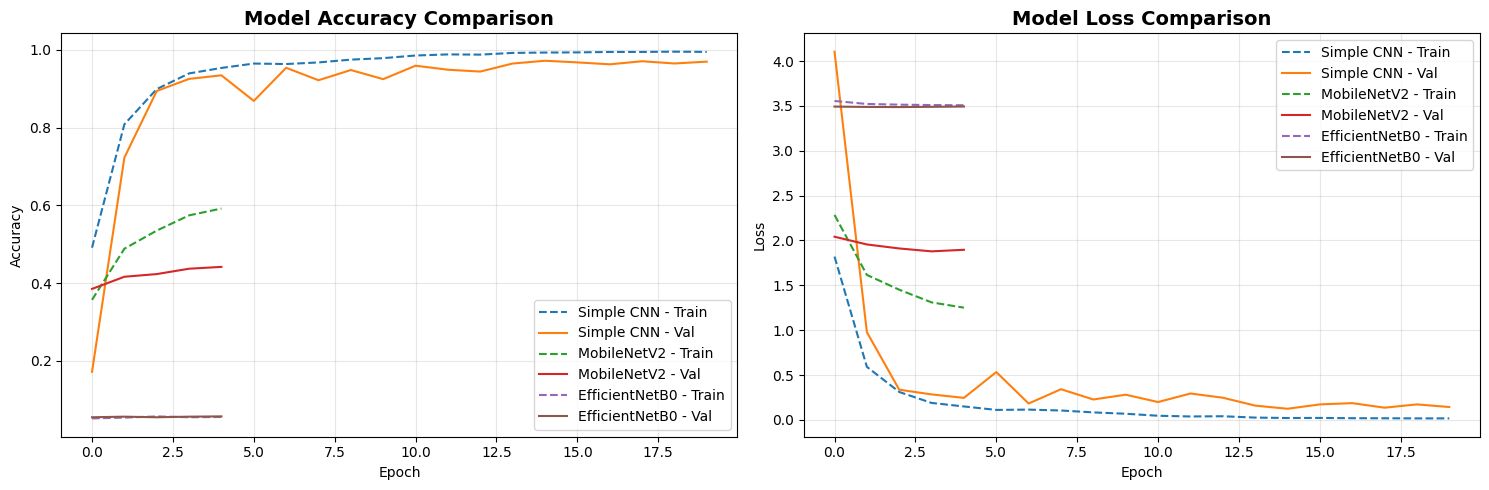


FINAL VALIDATION METRICS
Simple CNN           - Accuracy: 0.9718 (97.18%)
MobileNetV2          - Accuracy: 0.3852 (38.52%)
EfficientNetB0       - Accuracy: 0.0551 (5.51%)


In [10]:
# 8. Model Comparison

# Compare Training Histories
def plot_training_history(histories, labels):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    for history, label in zip(histories, labels):
        axes[0].plot(history.history['accuracy'], label=f'{label} - Train', linestyle='--')
        axes[0].plot(history.history['val_accuracy'], label=f'{label} - Val')
    
    axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    for history, label in zip(histories, labels):
        axes[1].plot(history.history['loss'], label=f'{label} - Train', linestyle='--')
        axes[1].plot(history.history['val_loss'], label=f'{label} - Val')
    
    axes[1].set_title('Model Loss Comparison', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(
    [history_simple, history_mobile, history_efficient],
    ['Simple CNN', 'MobileNetV2', 'EfficientNetB0']
)

# Final Metrics
print("\n" + "="*50)
print("FINAL VALIDATION METRICS")
print("="*50)

models_dict = {
    'Simple CNN': model_simple,
    'MobileNetV2': model_mobile,
    'EfficientNetB0': model_efficient
}

for name, model in models_dict.items():
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"{name:20s} - Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

In [12]:
# 9. Save Best Model

# Select and Save Best Model
# Find best model
best_model_name = max(models_dict.keys(), 
                      key=lambda k: models_dict[k].evaluate(val_generator, verbose=0)[1])
best_model = models_dict[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")

# Save model
best_model.save('model/traffic_sign_classifier.h5')
print("✅ Model saved to 'model/traffic_sign_classifier.h5'")


🏆 Best Model: Simple CNN
✅ Model saved to 'model/traffic_sign_classifier.h5'


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step

CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)      0.977     1.000     0.988        42
                              Speed limit (30km/h)      0.938     0.982     0.959       444
                              Speed limit (50km/h)      1.000     1.000     1.000       402
                              Speed limit (60km/h)      0.984     0.939     0.961       264
                              Speed limit (70km/h)      0.991     1.000     0.995       420
                              Speed limit (80km/h)      0.995     0.970     0.982       432
                       End of speed limit (80km/h)      0.975     1.000     0.987       156
                             Speed limit (100km/h)      0.992     0.929     0.959       126
                             Speed limit (120km/h)      1.000     1.000     1.000        84
                

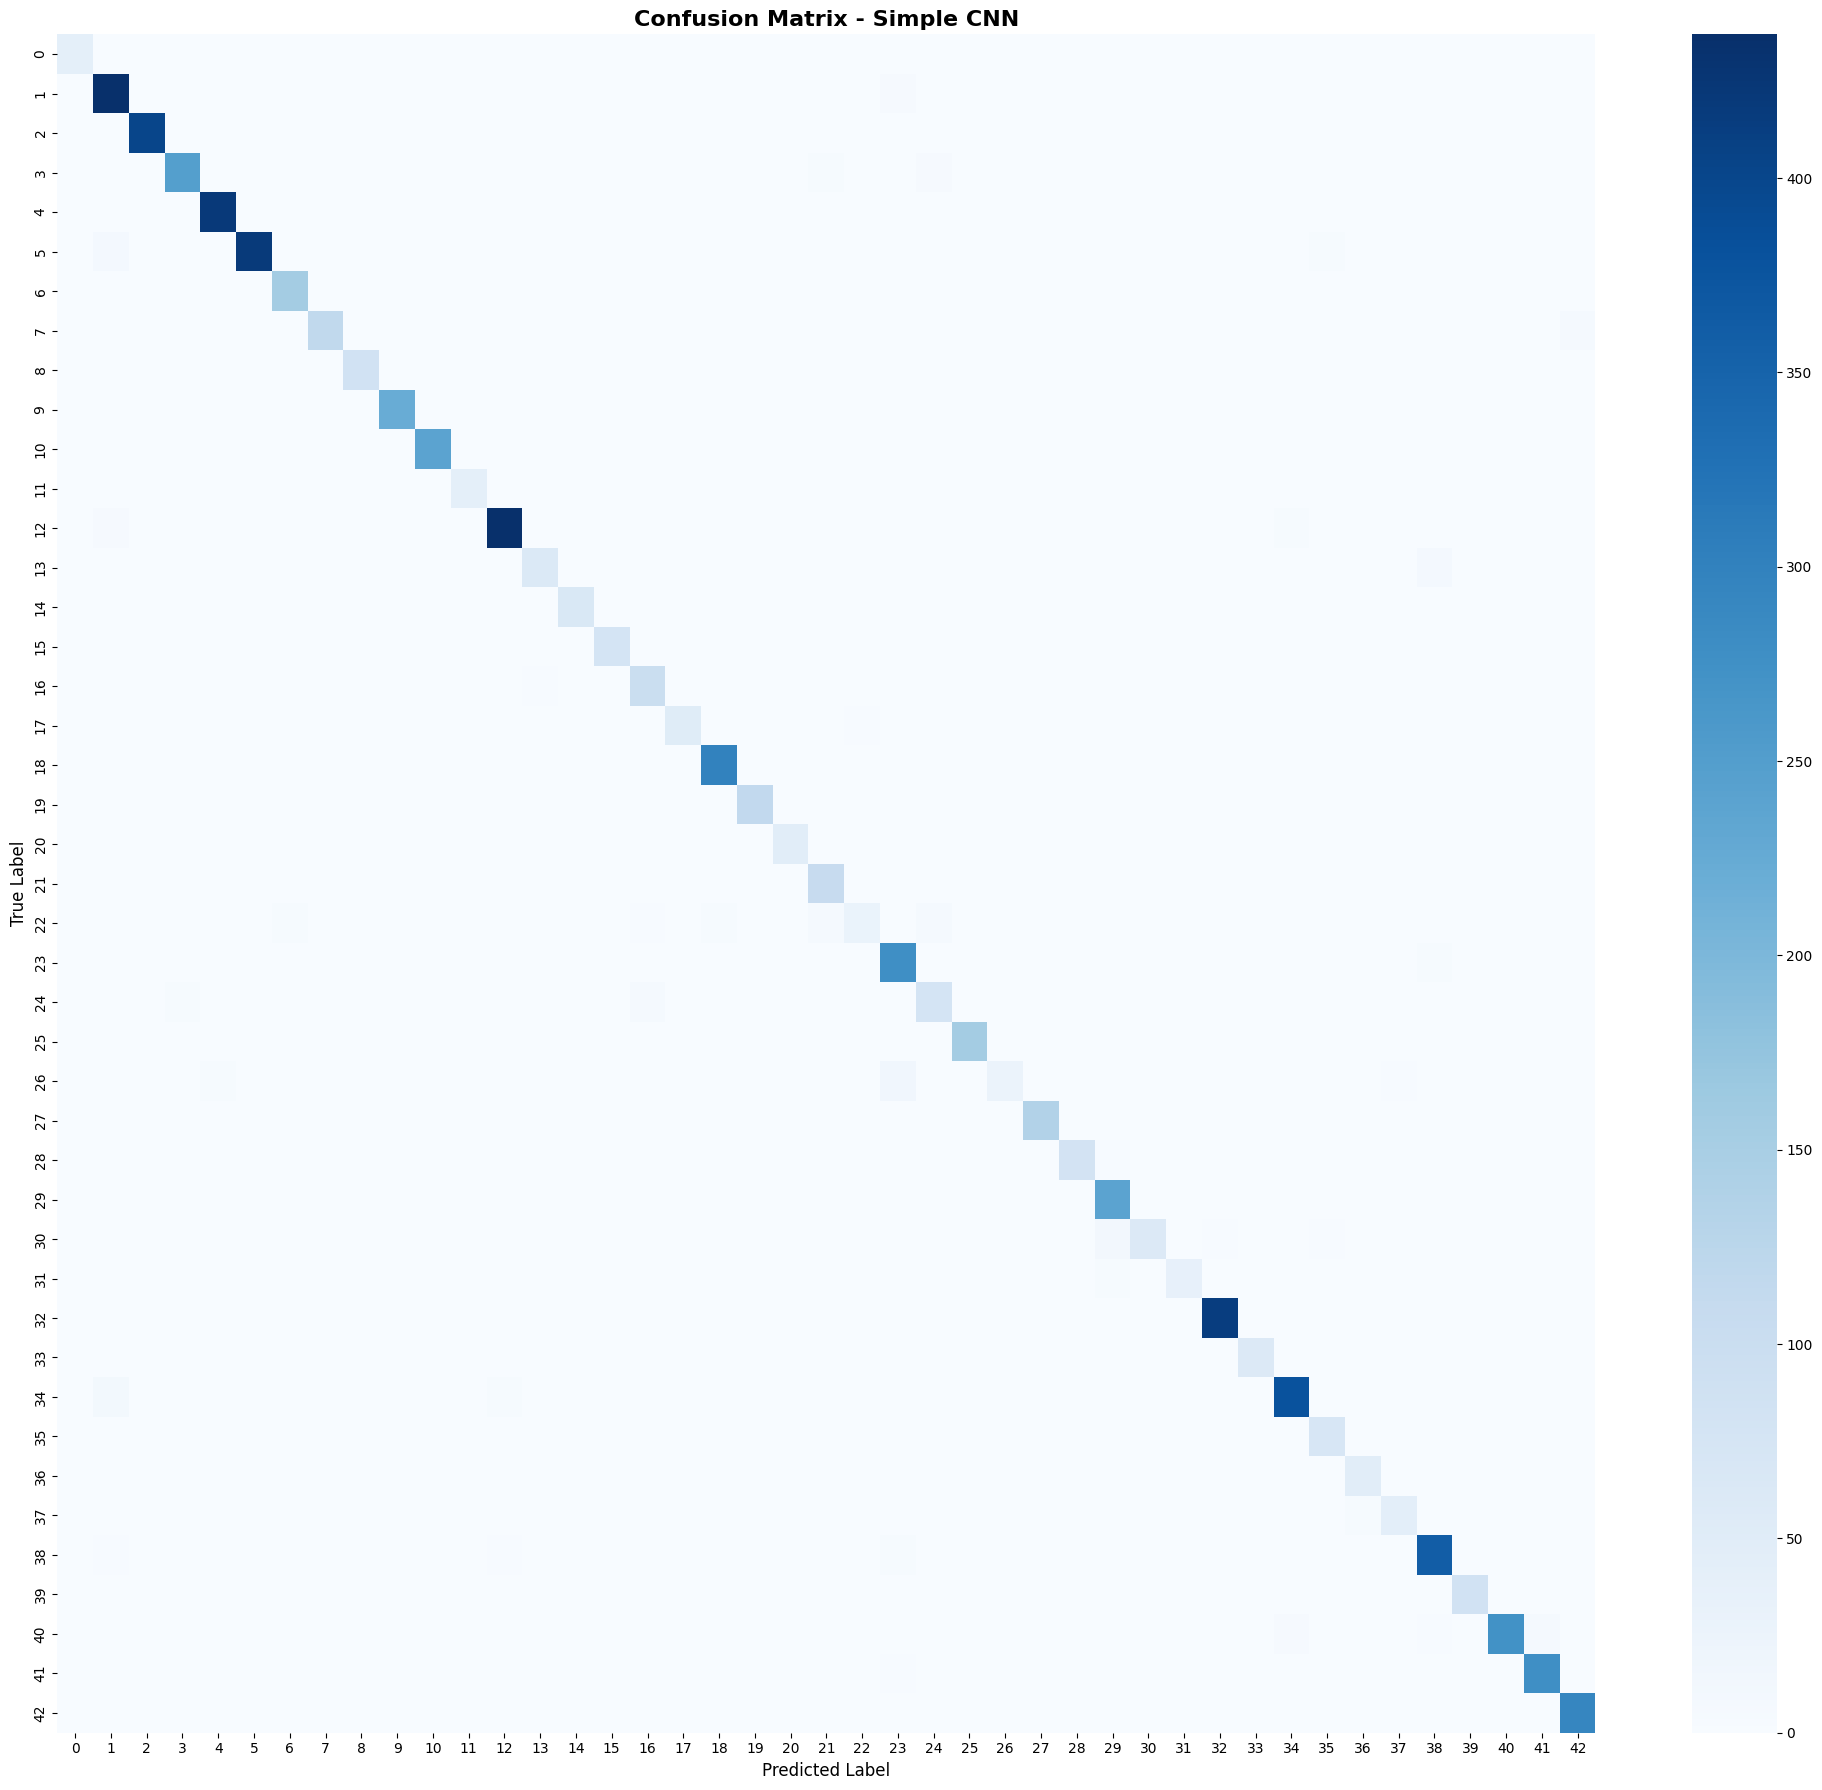


📊 Top 10 Most Confused Class Pairs:
----------------------------------------------------------------------
Traffic signals                → Slippery road                  : 16 errors
Beware of ice/snow             → Bicycles crossing              : 12 errors
Turn left ahead                → Speed limit (30km/h)           : 11 errors
Speed limit (80km/h)           → Speed limit (30km/h)           : 9 errors
Yield                          → Keep right                     : 9 errors
Speed limit (100km/h)          → End of no passing by vehicles  : 8 errors
Roundabout mandatory           → End of no passing              : 8 errors
Bumpy road                     → Double curve                   : 7 errors
Bumpy road                     → Road narrows on the right      : 7 errors
Road narrows on the right      → Vehicles over 3.5 metric tons  : 7 errors


In [13]:
# 10. Model Evaluation

# Predictions on Validation Set
val_generator.reset()
y_pred_probs = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

# Get class labels
class_labels = [class_names[i] for i in range(num_classes)]

# Print report for top 20 classes
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels,
    digits=3
)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Most Confused Classes
# Find top 10 most confused pairs
confused_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n📊 Top 10 Most Confused Class Pairs:")
print("-" * 70)
for true_class, pred_class, count in confused_pairs[:10]:
    print(f"{class_names[true_class][:30]:30s} → {class_names[pred_class][:30]:30s} : {count} errors")

In [ ]:
# 11. Test Sample Predictions

# Predict on Random Samples
def predict_samples(model, generator, num_samples=12):
    """Show predictions on random samples"""
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch[:num_samples])
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i in range(num_samples):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')
        
        true_label = np.argmax(y_batch[i])
        pred_label = np.argmax(predictions[i])
        confidence = np.max(predictions[i])
        
        color = 'green' if true_label == pred_label else 'red'
        
        title = f"True: {class_names[true_label][:20]}\n"
        title += f"Pred: {class_names[pred_label][:20]}\n"
        title += f"Conf: {confidence:.2%}"
        
        axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
    
    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

predict_samples(best_model, val_generator, num_samples=12)